In [1]:
from __future__ import division
import numpy as np
import sys,json,itertools,re,argparse
from collections import Counter,defaultdict

In [2]:
#matplotlib inline for jupyter notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## get the baseline, just predict the most seen argument for each predicate 

In [3]:
def get_true_argspans(pred_arg):
    true_args = []
    for k, v in pred_arg.iteritems():
        if k not in ['arg0', 'arg1', 'arg2', 'arg3', 'arg4']: continue 
        if v[0] == '-': continue 
        true_args.append((k, v))
    return true_args 

In [4]:
baseline_pred2arg2count = defaultdict(lambda : defaultdict(int))

#'TRAINING' on the baseline 
#get the baseline! --> for each predicate, find the most common argument, predict that
#go thru training data for this 
predargs_file = 'data/train.json'
for line in open(predargs_file, 'r'):
    predargs = json.loads(line)
    for pred_arg in predargs['pred_args']:
        predicate = unicode((pred_arg['pred_lemma'], pred_arg['pred_framesetID']))
        for arg_true, _ in get_true_argspans(pred_arg):
            baseline_pred2arg2count[predicate][arg_true] += 1

print len(baseline_pred2arg2count)

5282


In [5]:
#now make predictions just based on the max count 
baseline_pred2maxarg = {}
for pred, arg2count in baseline_pred2arg2count.iteritems():
    sorted_counts = sorted(arg2count.items(), key=lambda (k, v): -v)
    arg_pred = sorted_counts[0][0] 
    baseline_pred2maxarg[pred] = arg_pred

In [6]:
#'PREDICTING' on the baseline 
baseline_pred2numcorrect = Counter()
baseline_pred2total = Counter()
predargs_file = 'data/test.json'
for line in open(predargs_file, 'r'):
    predargs = json.loads(line)
    for pred_arg in predargs['pred_args']:
        predicate = unicode((pred_arg['pred_lemma'], pred_arg['pred_framesetID']))
        
        if predicate not in baseline_pred2maxarg.keys(): continue #we didn't see it at test time 
        
        for arg_true, _ in get_true_argspans(pred_arg):
            arg_pred = baseline_pred2maxarg[predicate]
            
            #then add to the counts
            if arg_pred == arg_true: baseline_pred2numcorrect[predicate] += 1 
            baseline_pred2total[predicate] += 1

#then calculate per-predicate accuracy 
baseline_pred2acc = {}
for predicate, numcorr in baseline_pred2numcorrect.iteritems():
    baseline_pred2acc[predicate] = numcorr / baseline_pred2total[predicate]

## load in the other predictions made from python test.py 

In [7]:
nsamp2pred2acc = {}
for nsamp in [1, 10, 100]:
    fin = 'accs/test_nsamp{0}_accs.json'.format(nsamp)
    nsamp2pred2acc[nsamp] = json.load(open(fin, 'r'))
#     print len(nsamp2pred2acc[nsamp])
#weird... why are these numbers different?? 

In [8]:
def get_pred_count(mode):
    pred2count = Counter()
    for line in open('data/{0}.json'.format(mode), 'r'):
        dd = json.loads(line)
        pred_args = dd['pred_args']
        for pred_arg in pred_args: 
            predicate = (pred_arg['pred_lemma'], pred_arg['pred_framesetID'])
            pred2count[str(predicate)] +=1 
            
    print 'NUM UNIQUE PREDS=', len(pred2count)
    return pred2count 

In [9]:
mode2pred2count = {}
for mode in ['train', 'test']:
    mode2pred2count[mode] = get_pred_count(mode)

NUM UNIQUE PREDS= 5287
NUM UNIQUE PREDS= 2406


In [10]:
#but how many predicates at test time in training? 
train_preds = mode2pred2count['train'].keys()
test_preds_all = mode2pred2count['test'].keys()
test_intersect = set(test_preds_all) & set(train_preds)
print len(test_intersect)

2295


In [11]:
#now I need this big print out
ww = open('preds_all.txt', 'w')
toprint = '{0:30} {1:10} {2:10} {3:10} {4:10} {5:10} {6:10}'.format('PREDICATE', 'train_count', 'test_count', 'baseline_acc','greedy_acc', '10samp_acc', '100samp_acc')
print toprint
x = []; y = []
ww.write(toprint+'\n')
for pred in nsamp2pred2acc[1].keys():
    if pred not in nsamp2pred2acc[10].keys() or pred not in nsamp2pred2acc[100].keys() or pred not in baseline_pred2acc.keys(): continue #happens when greedy doesn't have something??  
    x.append(nsamp2pred2acc[1][pred])
    y.append(nsamp2pred2acc[100][pred])
    toprint = '{0:25} {1:10} {2:10} {3:10.3} {4:10.3} {5:10.3} {6:10.3}'.format(pred, mode2pred2count['train'][pred], mode2pred2count['test'][pred], baseline_pred2acc[pred], nsamp2pred2acc[1][pred], nsamp2pred2acc[10][pred], nsamp2pred2acc[100][pred])
    print toprint
    ww.write(toprint +'\n')
ww.close()

PREDICATE                      train_count test_count baseline_acc greedy_acc 10samp_acc 100samp_acc
(u'reproduce', u'01')             18          2        0.5       0.25       0.25       0.25
(u'join', u'01')                 211         17       0.41      0.744      0.769      0.769
(u'trap', u'01')                  19          1        0.5        0.5        1.0        1.0
(u'become', u'01')              1067        124      0.377      0.684      0.699      0.702
(u'fool', u'01')                  41          2        0.5        1.0        1.0        1.0
(u'date', u'01')                  32          3      0.429      0.429      0.429      0.429
(u'shed', u'01')                  12          1      0.333      0.667      0.667      0.667
(u'boil', u'01')                   9          1      0.333      0.333      0.333      0.333
(u'total', u'01')                 88          8        0.4       0.75       0.85       0.85
(u'speed', u'02')                 16          2        0.5       0.25  

(u'intention', u'01')             21          4      0.364      0.455      0.455      0.455
(u'drive', u'02')                118          4        0.4        0.5        0.7        0.7
(u'carry', u'01')                285         36      0.396      0.626      0.637      0.615
(u'survival', u'01')              24          1      0.333      0.333      0.333      0.333
(u'mess', u'01')                   3          1        0.5        1.0        1.0        1.0
(u'appoint', u'01')               78          2        0.5       0.25        0.5        0.5
(u'swallow', u'01')               15          2        0.5        1.0        1.0        1.0
(u'end', u'03')                   82          7      0.333      0.571      0.571      0.571
(u'reach', u'01')                530         57      0.383      0.584      0.604      0.604
(u'grant', u'01')                 74         11      0.344      0.469      0.531      0.594
(u'fuel', u'01')                  30          2      0.286      0.286      0.286

(u'carry', u'03')                136         30      0.375      0.512      0.512      0.487
(u'violate', u'01')               80         12      0.353      0.382      0.382      0.412
(u'work', u'02')                  39          3       0.75       0.75       0.75        0.5
(u'education', u'01')            101          3      0.333      0.444      0.444      0.444
(u'tear', u'01')                  37          7       0.35       0.35       0.35       0.35
(u'go', u'07')                     7          2      0.333      0.667      0.667      0.667
(u'pick', u'04')                 104         10      0.417       0.75       0.75       0.75
(u'spit', u'01')                  10          1      0.333      0.667      0.667      0.667
(u'warning', u'01')               29          6        0.4        0.4      0.429        0.4
(u'embarrass', u'01')             13          2      0.333      0.333      0.333      0.333
(u'prevent', u'01')              154          9       0.36        0.4       0.36

(u'direction', u'01')              6          1      0.333      0.333      0.333      0.333
(u'run', u'09')                   19          3      0.375        0.5        0.5        0.5
(u'come', u'14')                   2          1      0.333      0.667      0.667      0.667
(u'retirement', u'01')            27          1        0.5        0.5        0.5        0.5
(u'dictate', u'01')               12          1      0.333      0.333      0.333      0.333
(u'give', u'02')                  14          1      0.333      0.333      0.333      0.333
(u'suspension', u'01')             4          2      0.333        0.5        0.4        0.4
(u'go', u'01')                   452         45      0.372      0.479      0.492      0.504
(u'choose', u'01')               365         33      0.364       0.58      0.568      0.557
(u'add', u'04')                   13          1      0.333      0.667      0.667      0.667
(u'televise', u'01')              13          2      0.333        0.5        0.5

(u'save', u'03')                  27          1      0.333      0.667        1.0        1.0
(u'concur', u'01')                 3          1      0.333      0.333      0.333      0.333
(u'cover', u'04')                  5          2        0.4        0.6        0.6        0.6
(u'quell', u'01')                  8          1      0.333      0.667      0.667      0.667
(u'debate', u'01')                76          7      0.368      0.368      0.316      0.316
(u'improvise', u'01')              5          1        0.5        0.5        0.5        0.5
(u'substitute', u'01')             9          3      0.273      0.727      0.727      0.636
(u'misstate', u'01')              10          1        1.0        1.0        1.0        1.0
(u'summon', u'01')                 9          1      0.333      0.333      0.333      0.333
(u'credit', u'01')                20          4      0.333        0.5        0.5        0.5
(u'start', u'01')                739         62      0.411      0.459      0.438

In [12]:
#GET THE MEAN OF EACH OF THE PREDICTIONS! 
mm = np.mean(np.array(baseline_pred2acc.values()))
print 'BASELINE'
print 'MEAN=', round(mm, 3) 
print ''

for nsamp in [1, 10, 100]:
    mm = np.mean(np.array(nsamp2pred2acc[nsamp].values()))
    print 'NSAMP=',nsamp
    print 'MEAN=', round(mm, 3) 
    print ''

BASELINE
MEAN= 0.393

NSAMP= 1
MEAN= 0.496

NSAMP= 10
MEAN= 0.527

NSAMP= 100
MEAN= 0.529



/home/kkeith/.virtualenvs/hk/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


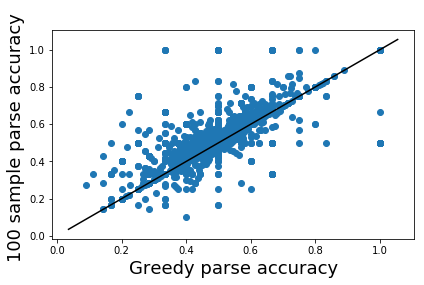

In [13]:
def abline(slope, intercept, plt):
    """Plot a line from slope and intercept"""  # https://stackoverflow.com/questions/7941226/add-line-based-on-slope-and-intercept-in-matplotlib
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color='black')

#now plot greedy vs. 100 sample accuracies 
# plot the loss history
font = {'fontname':'Times New Roman'}
plt.scatter(x, y)
plt.xlabel('Greedy parse accuracy', fontsize=18, **font)
plt.ylabel('100 sample parse accuracy ', fontsize=18, **font)
#plt.title('Comparison of accurracies of the two parse methods')
abline(1, 0, plt)
plt.tight_layout()
plt.savefig('../writing/compare_accs')
plt.show()